In [1]:
from torchvision import models
transfer_model = models.resnet50(pretrained=True)
print(transfer_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
# Freeze all parameters except batchnormalizations.
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [3]:
# Changing last layer of resnet.
import torch.nn as nn
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500), 
                                  nn.ReLU(), 
                                  nn.Dropout(), 
                                  nn.Linear(500,2))

In [4]:
import torchvision.transforms as transforms
transforms = transforms.Compose([transforms.Resize((64, 64)),
                                 # Changes brightness, contrast and saturation values of images randomly.
                                 transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0), 
                                 # Random flip process on images. p is chance of the reflection.
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.0),
                                 # Applying gray scale on images by the chance of 10%.
                                 transforms.RandomGrayscale(p=0.1),
                                 # Random crop process on imgaes.
                                 # transforms.RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='reflect'),
                                 # transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
                                 # Applying rotation to images
                                 # transforms.RandomRotation(degrees, resample=False,expand=False, center=None),
                                 # Adding padding
                                 # transforms.Pad(padding, fill=0, padding_mode=constant),
                                 # Adding shear, degree etc.
                                 transforms.RandomAffine(45, translate=None, scale=None, shear=0.4, resample=False, fillcolor=0),
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
import torchvision
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms)

val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=transforms)

test_data_path = "./test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=transforms)

In [6]:
import torch.utils.data as data
batch_size=64
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = data.DataLoader(val_data, batch_size=batch_size)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size)

In [7]:
import torch
import torch.optim as optim
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()   # training mode
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()   # evaluation mode for test.
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

In [9]:
import torch.nn.functional as F
train(transfer_model, optimizer, loss_fn, train_data_loader, val_data_loader, epochs=20)

Epoch: 0, Training Loss: 0.70, Validation Loss: 0.38, accuracy = 0.85
Epoch: 1, Training Loss: 0.47, Validation Loss: 0.24, accuracy = 0.94
Epoch: 2, Training Loss: 0.34, Validation Loss: 0.20, accuracy = 0.90
Epoch: 3, Training Loss: 0.26, Validation Loss: 0.20, accuracy = 0.90
Epoch: 4, Training Loss: 0.25, Validation Loss: 0.27, accuracy = 0.89
Epoch: 5, Training Loss: 0.20, Validation Loss: 0.18, accuracy = 0.88
Epoch: 6, Training Loss: 0.19, Validation Loss: 0.15, accuracy = 0.95
Epoch: 7, Training Loss: 0.20, Validation Loss: 0.20, accuracy = 0.92
Epoch: 8, Training Loss: 0.18, Validation Loss: 0.21, accuracy = 0.91
Epoch: 9, Training Loss: 0.15, Validation Loss: 0.25, accuracy = 0.91
Epoch: 10, Training Loss: 0.18, Validation Loss: 0.14, accuracy = 0.93
Epoch: 11, Training Loss: 0.11, Validation Loss: 0.24, accuracy = 0.86
Epoch: 12, Training Loss: 0.13, Validation Loss: 0.09, accuracy = 0.95
Epoch: 13, Training Loss: 0.14, Validation Loss: 0.21, accuracy = 0.88
Epoch: 14, Train

In [10]:
corrects = 0
total = 0
for batch in test_data_loader:
    inputs, targets = batch
    prediction = transfer_model(inputs)
    correct = torch.eq(torch.max(F.softmax(prediction, dim=1), dim=1)[1], targets).view(-1)
    correct_num = torch.sum(correct)
    total_instance = correct.size()[0]
    corrects += correct_num.item()
    total += total_instance
print("Model accuracy on test data: {}%".format(round(corrects/total*100,2)))

Model accuracy on test data: 92.59%


# Finding That Learning Rate

In [11]:
alexnet = models.alexnet(num_classes=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [12]:
import math
def find_lr(model, loss_fn, optimizer,  train_loader, init_value=1e-4, final_value=1):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs, losses
        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss
        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))
        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs, losses

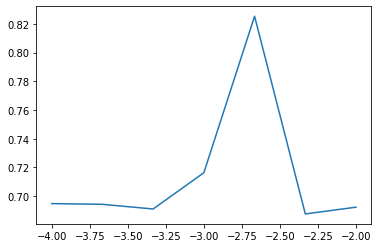

In [13]:
import matplotlib.pyplot as plt
logs,losses = find_lr(alexnet, loss_fn, optimizer, train_data_loader)
plt.plot(logs,losses)

In [14]:
found_lr = 10**(-2.5)

# Differential Learning Rates

In [15]:
optimizer = optim.Adam([{ 'params': transfer_model.layer4.parameters(), 'lr': found_lr /3}, { 'params': transfer_model.layer3.parameters(), 'lr': found_lr /9}], 
                           lr=found_lr)

In [16]:
# For unfreezing layers.
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True